In [74]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from dotenv import load_dotenv 
from datetime import datetime
import cohere
import faiss
from tqdm import tqdm
import praw

import re

import warnings
warnings.filterwarnings('ignore')

from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.output_parsers import RetryWithErrorOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAi
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

import openai
from datasets import load_dataset, Dataset

from googleapiclient.discovery import build
import time

import sys
import os
from pathlib import Path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
os.chdir("/Users/emmanueladeleye/Documents/DS Projects/E-Commerce-Multisource-Review-Analaysis-Product-QA")

from src.scraper import *
from src.product_review import *

ImportError: cannot import name 'ChatOpenAi' from 'langchain.chat_models' (/opt/anaconda3/lib/python3.12/site-packages/langchain/chat_models/__init__.py)

In [2]:
# Model evaluation test cases
test_cases = [
    # CATEGORY: SOFTWARE
    {
        "question": "What is the specific fix for Lightroom crashing when opening the Develop module?",
        "ground_truth": "Users found that rolling back the graphics card driver in the device manager fixed the crashing issue, as disabling GPU acceleration slowed down performance too much."
    },
    {
        "question": "Which software and hardware are recommended for a 3-2-1 photo backup system?",
        "ground_truth": "A reliable setup includes a 1.5TB mini SD card for primary storage, a WD 5TB Passport for monthly off-site backups, and the PhotoSync app to sync mobile photos to a NAS."
    },
    {
        "question": "Is Zerene Stacker recommended for macro photography and how much does it cost?",
        "ground_truth": "Yes, it is focus-stacking software specifically designed for challenging macro subjects, with prices starting from $39."
    },

    # CATEGORY: CAMERA
    {
        "question": "Are there reported focus issues with the Sony 70-350 lens for wildlife photography?",
        "ground_truth": "Yes, users reported that the lens often fails to focus at a distance, resulting in blurry photos even when using settings like 'sport mode'."
    },
    {
        "question": "What are the concerns regarding firmware updates for Sony cameras bought on the gray market?",
        "ground_truth": "Buyers are concerned that gray market units may not support standard firmware updates available to store-bought versions, which is a problem since updates are often seen as a necessity for models like the A7ii."
    },
    {
        "question": "Why does the GoPro HERO3 battery receive mixed reviews regarding its reliability?",
        "ground_truth": "While some users find it 'ok', others have reported it failing to work as expected, leading to complaints about negative review suppression on retail sites."
    },

    # CATEGORY: MOBILE ELECTRONICS
    {
        "question": "Why do high-quality iPhone videos look soft or blurry when uploaded as Instagram Reels?",
        "ground_truth": "Despite enabling 'high quality upload', professionally sharp footage often becomes soft in-app; users have tested various DPI (72 vs 300) and resolutions without a consistent fix."
    },
    {
        "question": "Is the Sekonic L-208 Twinmaster a good exposure meter for iPhone photographers?",
        "ground_truth": "Yes, it is recommended because it is small, inexpensive, rugged, and can be clipped directly onto a camera's hot shoe for convenience."
    },
    {
        "question": "What are the main complaints about the iPhone 16 Pro camera performance in low light?",
        "ground_truth": "Users complain that lights cause subjects to disappear into a 'dark mush' and that the 48MP mode only triggers in perfect lighting, often defaulting to 12MP in typical conditions."
    }
]

In [4]:
openai_key = os.getenv("openai_api")

In [3]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
import random

response_schemas_a = [
    ResponseSchema(name="question", description="A specific question a user might ask based on the review text"),
    ResponseSchema(name="ground_truth", description="The specific answer found in the text")
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas_a)
format_instructions_a = output_parser.get_format_instructions()

In [ ]:
def generate_synthetic_test(corpus_chunk):
    llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo", api_key=openai_key)
    prompt = ChatPromptTemplate.from_template(
        """
        You are a QA generator. Read the review text below and create ONE specific question and its answer based *only* on the text provided.
        
        Review Text:
        {text}
        
        {format_instructions}
        """)
    chain = prompt | llm | output_parser

    try:
        return chain.invoke({"text": corpus_chunk, "format_instructions": format_instructions_a})
    except Exception as e:
        print(f"Error generating test case: {e}")
        return None

In [32]:
data = pd.read_csv("data/processed_amzn_reviews_2023.csv", index_col=False)
amzn_review_data_2023 = data["0"].tolist()

data_2 = pd.read_csv("data/processed_amzn_product_2023.csv", index_col=False)
amzn_prod_data_2023 = data_2["0"].tolist()

data_3 = pd.read_csv("data/processed_social_media_corpus.csv", index_col=False)
sm_data = data_3["0"].tolist()

#### **Augment Analyse Text Function**

In [75]:
def robust_analyze_text(self, relevant_text, state, ground_query):
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0.3,
        api_key=openai_key
    )
    if state == "social_media":
        template_str = """
        You are a product sentiment analysis assistant. User query: "{query}"
        Analyze the social media corpus below.
        Return output strictly as valid JSON conforming to the format instructions.
        
        Corpus:
        {text}
        
        {format_instructions}
        """
        parser = self.output_parser_1

    elif state == "amazon":
        template_str = """
        You are a product sentiment assistant. User query: "{query}"
        Analyze the Amazon reviews below.
        Return output strictly as valid JSON conforming to the format instructions.
        
        Corpus:
        {text}
        
        {format_instructions}
        """
        parser = self.output_parser_2
        
    elif state == "final":
        template_str = """
        You are a recommendation assistant. User intent: "{initial_query}"
        Analyze the product summary below.
        Return output strictly as valid JSON conforming to the format instructions.
        
        Context:
        {text}
        
        {format_instructions}
        """
        parser = self.output_parser_3
        
    else:
        raise ValueError("Invalid State")

    prompt = ChatPromptTemplate.from_template(template_str)
    retry_parser = RetryWithErrorOutputParser.from_llm(parser=parser, llm=llm)   
    prompt_value = prompt.format_prompt(
        query = self.sub_query,
        initial_query = ground_query,
        text=relevant_text,
        format_instructions=parser.get_format_instructions()
    )
    raw_output = llm.invoke(prompt_value).content

    try:
        parsed_result = retry_parser.parse_with_prompt(raw_output, prompt_value)
        return parsed_result, relevant_text
    except Exception as e:
        print(f"Error parsing output: {e}")
        return None, relevant_text

ProductReview._analyze_text = robust_analyze_text
print("Successfully patched ProductReview._analyze_text with robust parsing.")

Successfully patched ProductReview._analyze_text with robust parsing.


#### **Generating Synthetic Data**

In [30]:
sample_reviews = random.sample(amzn_review_data_2023, 5)
synthetic_cases = []

print("Generating synthetic test cases...")
for review in sample_reviews:
    qa_result = generate_synthetic_test(review[:1000])
    if qa_result:
        synthetic_cases.append(qa_result)

print(f"Generated {len(synthetic_cases)} synthetic test cases.")
print(synthetic_cases[0]) # Inspect one example

Generating synthetic test cases...
Generated 5 synthetic test cases.
{'question': 'What type of design does the COTDINFORCA iPhone Xs Max case have?', 'ground_truth': 'Mirror Design Clear View Flip Bookstyle'}


In [31]:
synthetic_cases

[{'question': 'What type of design does the COTDINFORCA iPhone Xs Max case have?',
  'ground_truth': 'Mirror Design Clear View Flip Bookstyle'},
 {'question': 'What are some key features of the product for the galaxy A52 phone?',
  'ground_truth': 'Well-finish, stylish, protective, durable and affordable'},
 {'question': 'What contributes to the excellent low-light performance mentioned in the review?',
  'ground_truth': 'A backside illuminated sensor and wide aperture lens f2.2'},
 {'question': 'What type of damage does the cell phone protector help to protect against?',
  'ground_truth': 'Helps to protect against shock and surface damage caused by accidental drops.'},
 {'question': 'What issue may arise when using the included metal plate with certain devices?',
  'ground_truth': 'The included metal plate may not work properly with devices that feature a curved back.'}]

#### **Running Evaluator**

In [34]:
from ragas import evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)

In [76]:
results_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": []
}

print("Evaluating synthetic test cases...")
for case in synthetic_cases:

    reviewer = ProductReview("Phones & Accessories", case["question"], 
                             amzn_review_data_2023, amzn_prod_data_2023, sm_data = sm_data, 
                             state = "amazon", 
                             format_instructions_1=format_instructions_1, format_instructions_2=format_instructions_2, format_instructions_3=format_instructions_3, 
                             openai_key=openai_key, 
                             output_parser_1=output_parser_1, output_parser_2=output_parser_2, output_parser_3=output_parser_3)
    
    results_json, retrieved_context = reviewer._analyze_with_semantic_search(reviewer.amzn_reviews, state="amazon")

    answer_text = " ".join(results_json["Amazon review sentiment"])

    results_data["question"].append(case["question"])
    results_data["answer"].append(answer_text)
    results_data["contexts"].append([retrieved_context]) # Ragas expects a list of strings
    results_data["ground_truth"].append(case["ground_truth"])

print("Generation complete. Computing evaluation metrics...")

Evaluating synthetic test cases...
--------------------------------------------------------------------------------------------------------------------
First layer BM25 Retriever Corpus Reduction Complete
Embeddings vector created..
Semantic Search Completed
Total number of relevant text: 4087

--------------------------------------------------------------------------------------------------------------------
First layer BM25 Retriever Corpus Reduction Complete
Embeddings vector created..
Semantic Search Completed
Total number of relevant text: 3491

--------------------------------------------------------------------------------------------------------------------
First layer BM25 Retriever Corpus Reduction Complete
Embeddings vector created..
Semantic Search Completed
Total number of relevant text: 3631

--------------------------------------------------------------------------------------------------------------------
First layer BM25 Retriever Corpus Reduction Complete
Embeddings v

#### **Computing Metrics**

In [40]:
os.environ["OPENAI_API_KEY"] = openai_key

In [69]:
gpt_turbo = ChatOpenAI(model="gpt-3.5-turbo")
openai_embeddings = OpenAIEmbeddings()

In [77]:
eval_dataset = Dataset.from_dict(results_data)

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]
scores = evaluate(eval_dataset, metrics, llm=gpt_turbo, embeddings=openai_embeddings)

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


In [78]:
df_results = scores.to_pandas()
display(df_results)

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision
0,What type of design does the COTDINFORCA iPhon...,[Cup Car Accessories Cup Phone Holder for Smar...,H i g h - q u a l i t y P U l e a t h e r ...,Mirror Design Clear View Flip Bookstyle,0.666667,0.824432,0.0,0.0
1,What are some key features of the product for ...,[Navigation Bracket Interior Decoration Mobile...,E n a b l e s o n e - h a n d e d o p e r ...,"Well-finish, stylish, protective, durable and ...",0.000000,0.881753,0.0,0.0
2,What contributes to the excellent low-light pe...,[Navigation Bracket Interior Decoration Mobile...,1 . E n a b l e s o n e - h a n d e d o ...,A backside illuminated sensor and wide apertur...,1.000000,0.764017,1.0,1.0
3,What type of damage does the cell phone protec...,[Cup Car Accessories Cup Phone Holder for Smar...,H i g h - q u a l i t y c a r p h o n e ...,Helps to protect against shock and surface dam...,0.600000,0.782960,1.0,0.0
4,What issue may arise when using the included m...,[Navigation Bracket Interior Decoration Mobile...,H i g h - q u a l i t y a c c e s s o r i e ...,The included metal plate may not work properly...,0.500000,0.766949,1.0,1.0


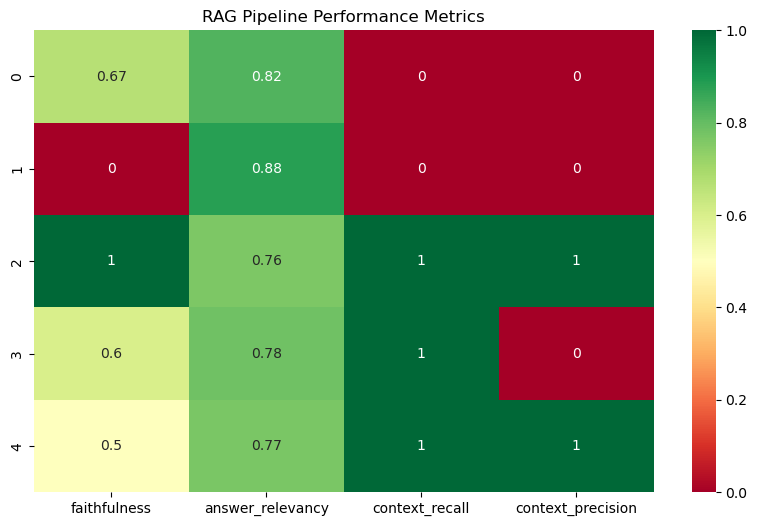

Potential Hallucinations:
Q: What type of design does the COTDINFORCA iPhone Xs Max case have?
A: H i g h - q u a l i t y   P U   l e a t h e r   m a t e r i a l ,   c r e a t i v e   p a i n t e d   d e s i g n ,   f u l l - b o d y   p r o t e c t i v e   c o v e r
---
Q: What are some key features of the product for the galaxy A52 phone?
A: E n a b l e s   o n e - h a n d e d   o p e r a t i o n ,   h i g h - q u a l i t y   m a t e r i a l s ,   f i t s   v a r i o u s   p h o n e   s i z e s
---
Q: What type of damage does the cell phone protector help to protect against?
A: H i g h - q u a l i t y   c a r   p h o n e   h o l d e r   f o r   2 0 2 2   H o n d a   C i v i c ,   e a s y   o n e - h a n d   o p e r a t i o n ,   f u l l y   p r o t e c t s   e x p e n s i v e   m o b i l e   p h o n e s
---
Q: What issue may arise when using the included metal plate with certain devices?
A: H i g h - q u a l i t y   a c c e s s o r i e s   a n d   e x p e r i e n c e s   o f   h e a 

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of scores
plt.figure(figsize=(10, 6))
sns.heatmap(df_results.iloc[:, 4:], annot=True, cmap="RdYlGn", vmin=0, vmax=1)
plt.title("RAG Pipeline Performance Metrics")
plt.show()

# Print low-faithfulness examples (Potential Hallucinations)
print("Potential Hallucinations:")
low_faith = df_results[df_results["faithfulness"] < 0.7]
for idx, row in low_faith.iterrows():
    print(f"Q: {row['user_input']}")
    print(f"A: {row['response']}")
    print("---")